In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os
from glob import glob #Glob to walk throgh the folder structure
from PIL import Image # to load the images and it makes it easy to resize the image and convert them into numpy area
                      # U can use opencv or sklearn for image processing

np.random.seed(42) # fixing the random seed so when I repeat the experiment we will get slightly good repetaated ones rather than completely random
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils  import to_categorical # used for converting labels to one-hot-encoded one
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization
from sklearn.model_selection  import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [9]:
skin_df=pd.read_csv(r'C:\Users\DELL\xyz\Internship Assignments\Softnerve Tech\archive (2)\HAM10000_metadata.csv')
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [10]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [11]:
skin_df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [12]:
le=LabelEncoder()
le.fit(skin_df['dx'])


LabelEncoder()

In [13]:
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [14]:
skin_df['label']=le.transform(skin_df['dx'])
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0


In [15]:
skin_df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
1617,HAM_0007180,ISIC_0033272,mel,histo,65.0,male,face,4
8128,HAM_0007195,ISIC_0031923,nv,histo,40.0,female,lower extremity,5
2168,HAM_0001835,ISIC_0026652,mel,histo,65.0,male,back,4
1090,HAM_0000465,ISIC_0030583,bkl,consensus,35.0,female,trunk,2
7754,HAM_0001720,ISIC_0034010,nv,histo,45.0,male,abdomen,5
8071,HAM_0006333,ISIC_0024424,nv,histo,35.0,male,trunk,5
7423,HAM_0004548,ISIC_0032832,nv,histo,45.0,female,upper extremity,5
8984,HAM_0006526,ISIC_0026671,nv,histo,55.0,male,lower extremity,5
2310,HAM_0003102,ISIC_0032389,mel,histo,65.0,male,face,4
7256,HAM_0004260,ISIC_0025525,nv,histo,65.0,male,back,5


F:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


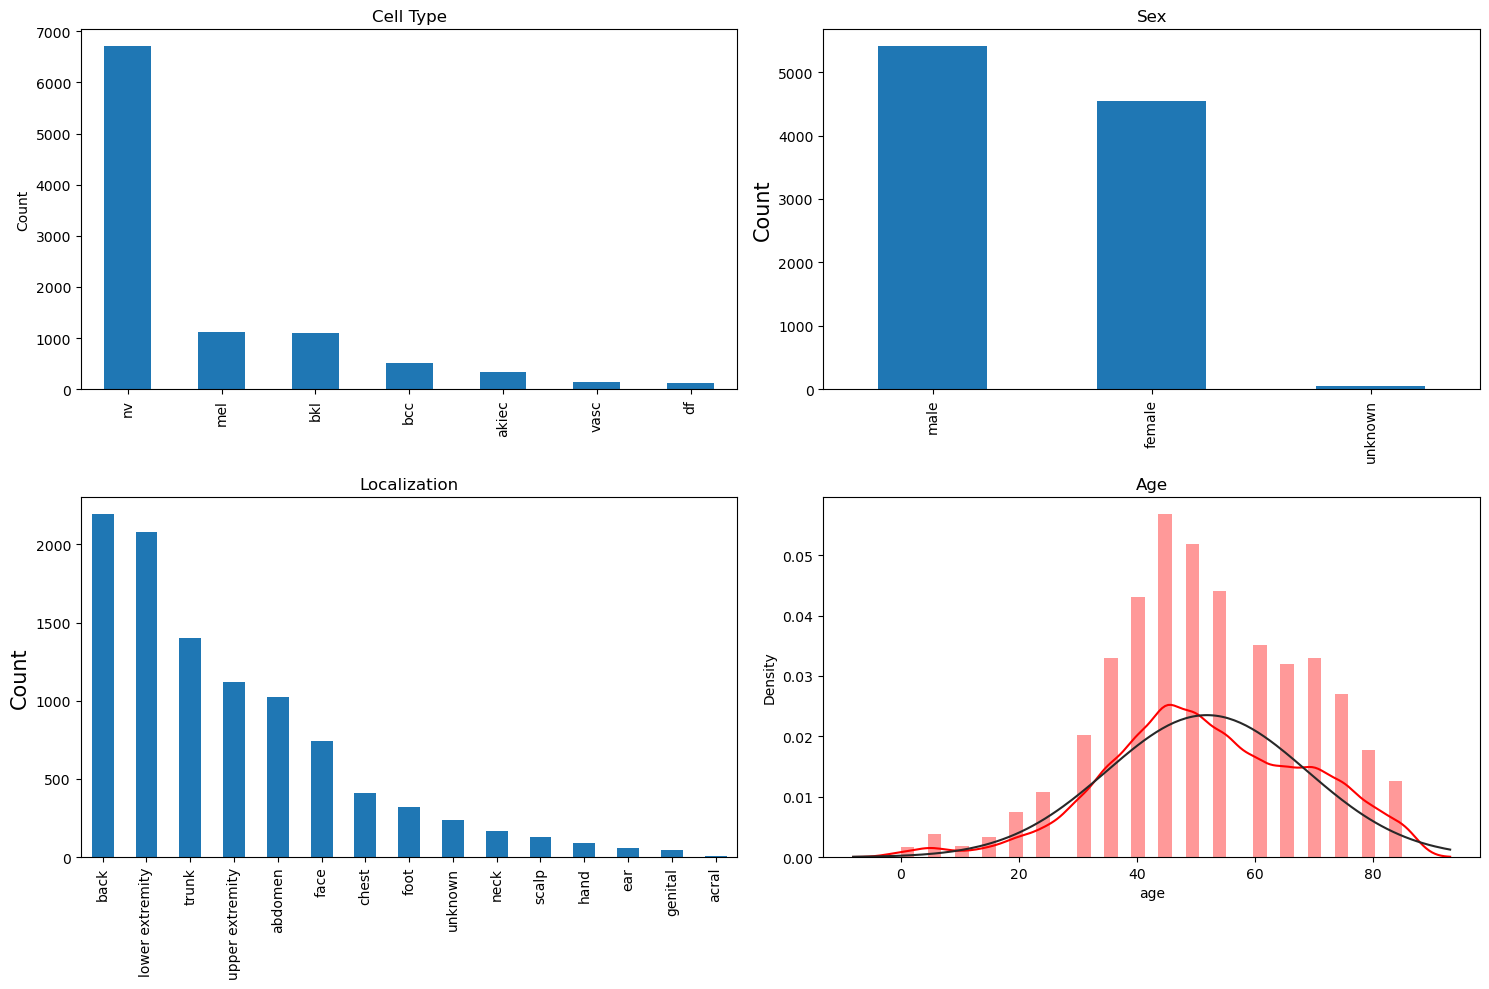

In [20]:
#Plot the graph to get the quick idea of how is the distribution

# Data Distribution Visualization
fig=plt.figure(figsize=(15,10))

ax1=fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar',ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')

ax2=fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar',ax=ax2)
ax2.set_ylabel('Count',size=15)
ax2.set_title('Sex')

ax3=fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=15)
ax3.set_title('Localization')

ax4=fig.add_subplot(224)
sample_age=skin_df[pd.notnull(skin_df['age'])]
sb.distplot(sample_age['age'],fit=stats.norm, color='red')
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [22]:
skin_df['label'].value_counts()

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64

In [23]:
# We can balance this unbalanced data first

#Balance data
#Many ways to balance data.. you can also try assumingweights during model creation orr
#seperate each classes,resample, and combine back into single dataframe
from sklearn.utils import resample

df_0=skin_df[skin_df['label']==0]
df_1=skin_df[skin_df['label']==1]
df_2=skin_df[skin_df['label']==2]
df_3=skin_df[skin_df['label']==3]
df_4=skin_df[skin_df['label']==4]
df_5=skin_df[skin_df['label']==5]
df_6=skin_df[skin_df['label']==6]

n_samples=500
df_0_balanced=resample(df_0,replace=True, n_samples=n_samples,random_state=42)
df_1_balanced=resample(df_1,replace=True, n_samples=n_samples,random_state=42)
df_2_balanced=resample(df_2,replace=True, n_samples=n_samples,random_state=42)
df_3_balanced=resample(df_3,replace=True, n_samples=n_samples,random_state=42)
df_4_balanced=resample(df_4,replace=True, n_samples=n_samples,random_state=42)
df_5_balanced=resample(df_5,replace=True, n_samples=n_samples,random_state=42)
df_6_balanced=resample(df_6,replace=True, n_samples=n_samples,random_state=42)
#upscale or downscale the data in each separate dataframe to have 500 entities.

#Combine all these dataframe into single dataframe
skin_df_balanced=pd.concat([df_0_balanced,df_1_balanced,df_2_balanced,df_3_balanced,df_4_balanced,df_5_balanced,df_6_balanced])

In [24]:
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0
...,...,...,...,...,...,...,...,...
2375,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,6
2436,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,6
2453,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,6
2377,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,6


In [27]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right  image is read for the right path

image_path={os.path.splitext(os.path.basename(x))[0]:x  for x in glob(os.path.join('C:/Users/DELL/xyz/Internship Assignments/Softnerve Tech/archive (2)','*','*.jpg'))}

In [28]:
image_path

{'ISIC_0024306': 'C:/Users/DELL/xyz/Internship Assignments/Softnerve Tech/archive (2)\\HAM10000_images_part_1\\ISIC_0024306.jpg',
 'ISIC_0024307': 'C:/Users/DELL/xyz/Internship Assignments/Softnerve Tech/archive (2)\\HAM10000_images_part_1\\ISIC_0024307.jpg',
 'ISIC_0024308': 'C:/Users/DELL/xyz/Internship Assignments/Softnerve Tech/archive (2)\\HAM10000_images_part_1\\ISIC_0024308.jpg',
 'ISIC_0024309': 'C:/Users/DELL/xyz/Internship Assignments/Softnerve Tech/archive (2)\\HAM10000_images_part_1\\ISIC_0024309.jpg',
 'ISIC_0024310': 'C:/Users/DELL/xyz/Internship Assignments/Softnerve Tech/archive (2)\\HAM10000_images_part_1\\ISIC_0024310.jpg',
 'ISIC_0024311': 'C:/Users/DELL/xyz/Internship Assignments/Softnerve Tech/archive (2)\\HAM10000_images_part_1\\ISIC_0024311.jpg',
 'ISIC_0024312': 'C:/Users/DELL/xyz/Internship Assignments/Softnerve Tech/archive (2)\\HAM10000_images_part_1\\ISIC_0024312.jpg',
 'ISIC_0024313': 'C:/Users/DELL/xyz/Internship Assignments/Softnerve Tech/archive (2)\\HAM

In [31]:
#Define the path and add a new column
skin_df_balanced['path']=skin_df['image_id'].map(image_path.get)
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,C:/Users/DELL/xyz/Internship Assignments/Softn...
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,C:/Users/DELL/xyz/Internship Assignments/Softn...
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,C:/Users/DELL/xyz/Internship Assignments/Softn...
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,C:/Users/DELL/xyz/Internship Assignments/Softn...
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,C:/Users/DELL/xyz/Internship Assignments/Softn...
...,...,...,...,...,...,...,...,...,...
2375,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,6,C:/Users/DELL/xyz/Internship Assignments/Softn...
2436,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,6,C:/Users/DELL/xyz/Internship Assignments/Softn...
2453,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,6,C:/Users/DELL/xyz/Internship Assignments/Softn...
2377,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,6,C:/Users/DELL/xyz/Internship Assignments/Softn...


In [32]:
SIZE=32  # or you can use image data generator method
#Use the path to read images
skin_df_balanced['image']=skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [33]:
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,C:/Users/DELL/xyz/Internship Assignments/Softn...,"[[[155, 118, 107], [162, 126, 118], [174, 140,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,C:/Users/DELL/xyz/Internship Assignments/Softn...,"[[[138, 76, 82], [131, 64, 68], [139, 73, 81],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,C:/Users/DELL/xyz/Internship Assignments/Softn...,"[[[123, 86, 87], [174, 137, 137], [197, 161, 1..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,C:/Users/DELL/xyz/Internship Assignments/Softn...,"[[[205, 149, 175], [207, 149, 169], [214, 158,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,C:/Users/DELL/xyz/Internship Assignments/Softn...,"[[[203, 174, 199], [205, 174, 197], [206, 175,..."
...,...,...,...,...,...,...,...,...,...,...
2375,HAM_0005989,ISIC_0033123,vasc,histo,25.0,female,back,6,C:/Users/DELL/xyz/Internship Assignments/Softn...,"[[[15, 12, 12], [40, 30, 32], [87, 67, 71], [1..."
2436,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,6,C:/Users/DELL/xyz/Internship Assignments/Softn...,"[[[148, 109, 118], [121, 93, 102], [112, 87, 9..."
2453,HAM_0001038,ISIC_0024706,vasc,consensus,50.0,male,trunk,6,C:/Users/DELL/xyz/Internship Assignments/Softn...,"[[[248, 181, 199], [248, 183, 201], [248, 186,..."
2377,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,6,C:/Users/DELL/xyz/Internship Assignments/Softn...,"[[[180, 133, 143], [189, 147, 158], [192, 150,..."


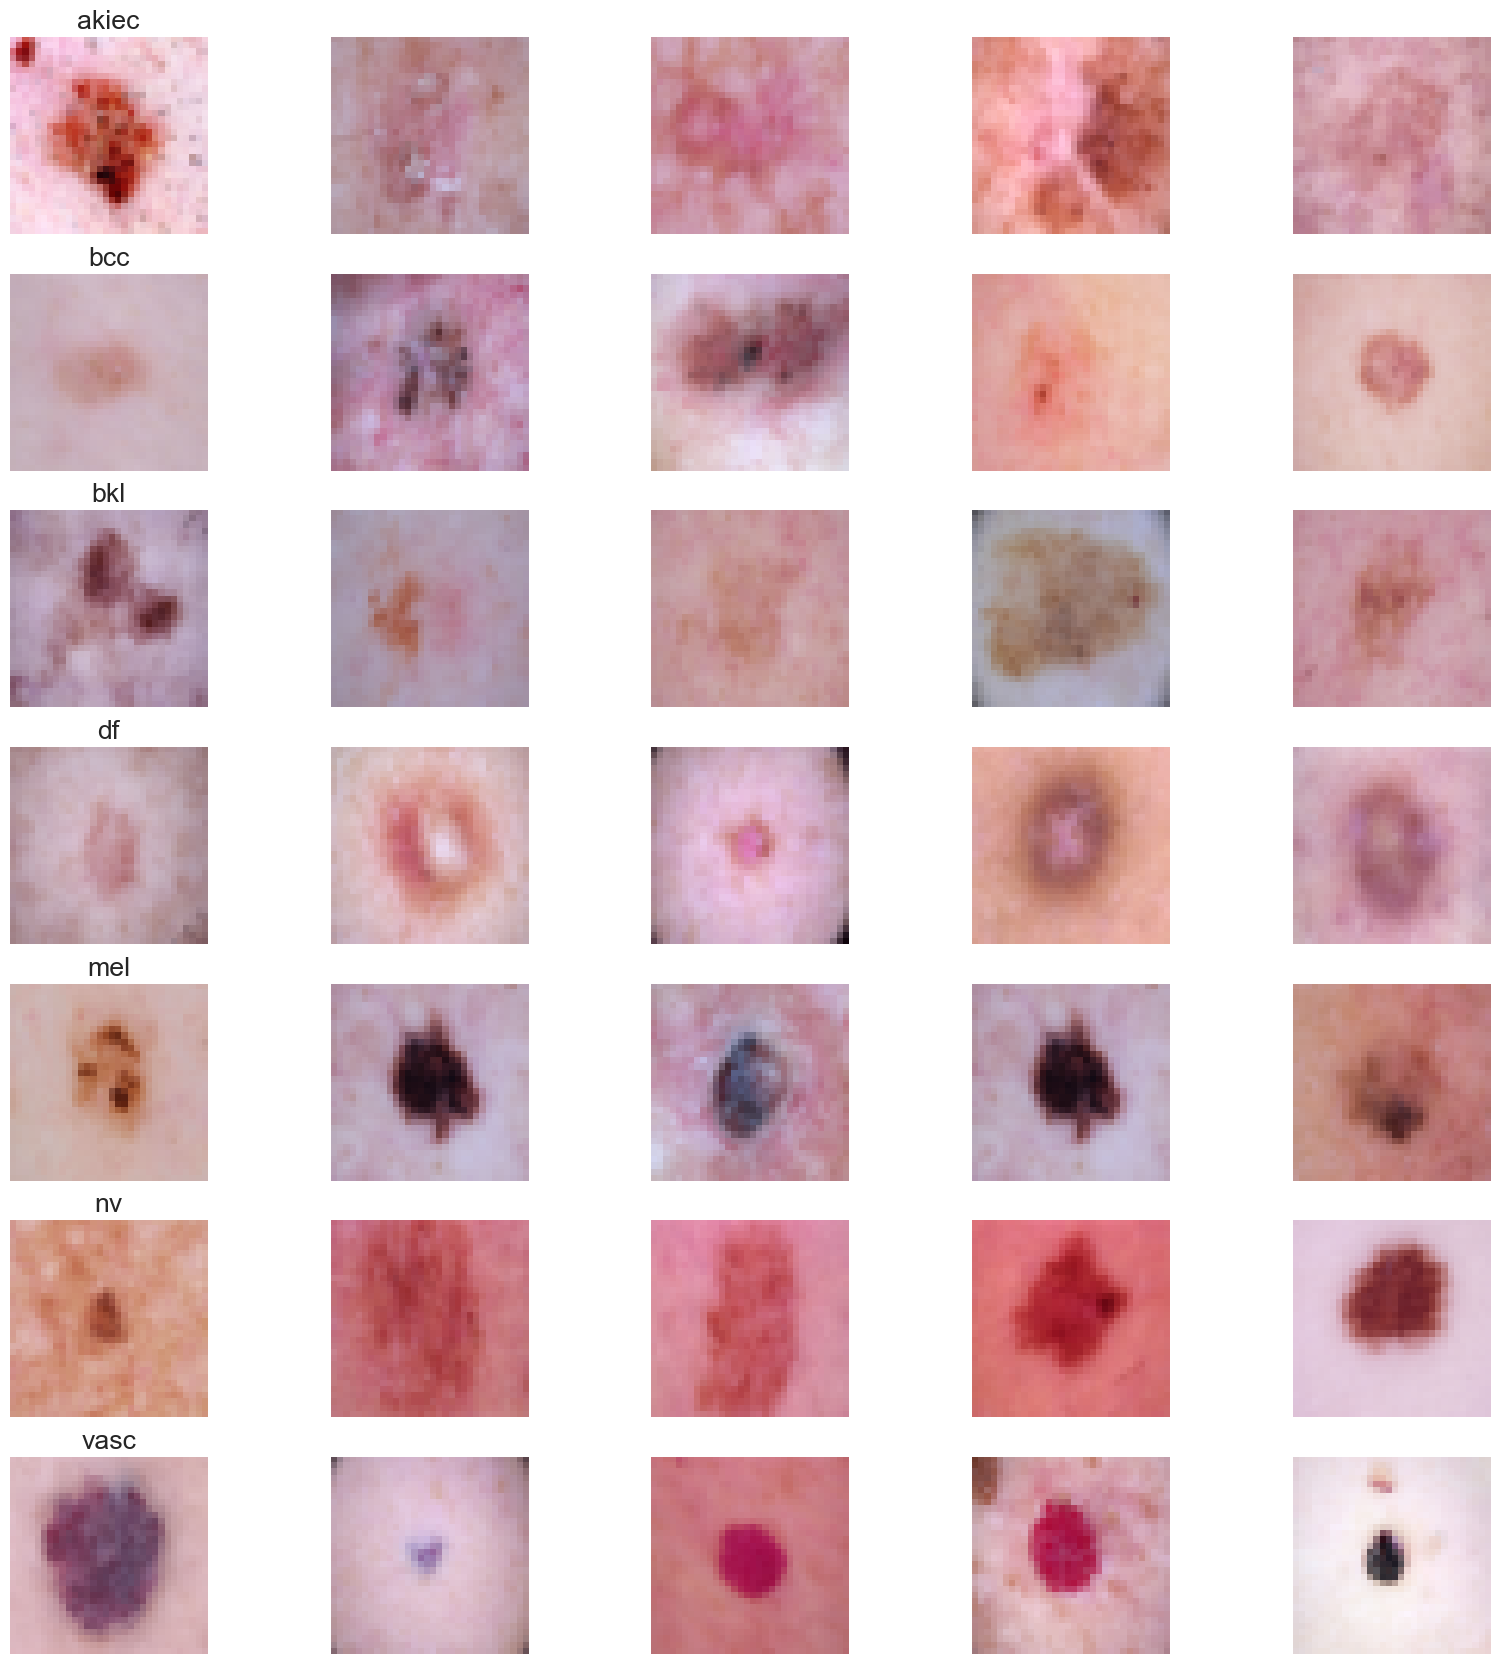

In [55]:
#Plot the images

n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [36]:
# Here x is input i.e. image and y is output i.e. label

#Convert dataframe column of images into numpy array
X=np.asarray(skin_df_balanced['image'].to_list())
X=X/255 # Scale values to 0 to 1. or Standardization or other scaling method
X

array([[[[0.60784314, 0.4627451 , 0.41960784],
         [0.63529412, 0.49411765, 0.4627451 ],
         [0.68235294, 0.54901961, 0.54117647],
         ...,
         [0.62352941, 0.4627451 , 0.40392157],
         [0.63137255, 0.50196078, 0.47058824],
         [0.53333333, 0.43137255, 0.40784314]],

        [[0.57647059, 0.41960784, 0.36470588],
         [0.61176471, 0.45882353, 0.41176471],
         [0.66666667, 0.52156863, 0.50196078],
         ...,
         [0.6745098 , 0.52156863, 0.4745098 ],
         [0.69019608, 0.56078431, 0.52156863],
         [0.6745098 , 0.56862745, 0.54509804]],

        [[0.64705882, 0.51372549, 0.48235294],
         [0.61176471, 0.45098039, 0.39215686],
         [0.61176471, 0.44313725, 0.40392157],
         ...,
         [0.6745098 , 0.52156863, 0.45882353],
         [0.65490196, 0.50980392, 0.44313725],
         [0.63137255, 0.50588235, 0.48235294]],

        ...,

        [[0.56470588, 0.42352941, 0.35294118],
         [0.58823529, 0.45098039, 0.37254902]

In [37]:
Y=skin_df_balanced['label'] #assign label to Y # you can use this for RF and other ML 
Y

9789    0
9957    0
9793    0
9758    0
9875    0
       ..
2375    6
2436    6
2453    6
2377    6
2363    6
Name: label, Length: 3500, dtype: int32

In [38]:
Y_cat= to_categorical(Y,num_classes=7) # Convert to categorical  as this is a multiclass classification
Y_cat                                  # use for deep learning multiclass classification

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [39]:
#Split the training and testing
x_train,x_test,y_train,y_test=train_test_split(X,Y_cat,test_size=0.25,random_state=42)

In [41]:
x_train.shape

(2625, 32, 32, 3)

In [42]:
x_test.shape

(875, 32, 32, 3)

In [43]:
#Define the model
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes=7

model=Sequential()
model.add(Conv2D(256,(3,3),activation='relu',input_shape=(SIZE,SIZE,3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7,activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['acc'])


#Train
#You can also use generator to use augmentation during training.

batch_size=16
epochs=100

history= model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,y_test),verbose=2)

score=model.evaluate(x_test,y_test)
score












Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

Epoch 53/100
165/165 - 11s - loss: 0.7063 - acc: 0.7341 - val_loss: 0.7873 - val_acc: 0.7314 - 11s/epoch - 67ms/step
Epoch 54/100
165/165 - 12s - loss: 0.6537 - acc: 0.7592 - val_loss: 0.7781 - val_acc: 0.7291 - 12s/epoch - 74ms/step
Epoch 55/100
165/165 - 11s - loss: 0.7721 - acc: 0.7143 - val_loss: 0.8750 - val_acc: 0.6880 - 11s/epoch - 66ms/step
Epoch 56/100
165/165 - 11s - loss: 0.6330 - acc: 0.7558 - val_loss: 0.7616 - val_acc: 0.7314 - 11s/epoch - 66ms/step
Epoch 57/100
165/165 - 11s - loss: 0.6003 - acc: 0.7832 - val_loss: 0.7883 - val_acc: 0.7280 - 11s/epoch - 65ms/step
Epoch 58/100
165/165 - 12s - loss: 0.6197 - acc: 0.7669 - val_loss: 0.8040 - val_acc: 0.7189 - 12s/epoch - 73ms/step
Epoch 59/100
165/165 - 11s - loss: 0.6188 - acc: 0.7775 - val_loss: 0.7683 - val_acc: 0.7349 - 11s/epoch - 69ms/step
Epoch 60/100
165/165 - 12s - loss: 0.6291 - acc: 0.7703 - val_loss: 0.7744 - val_acc: 0.7417 - 12s/epoch - 70ms/step
Epoch 61/100
165/165 - 11s - loss: 0.5663 - acc: 0.7909 - val_lo

[0.7517424821853638, 0.7542856931686401]

In [44]:
print('Test accuracy:',score[1])

Test accuracy: 0.7542856931686401


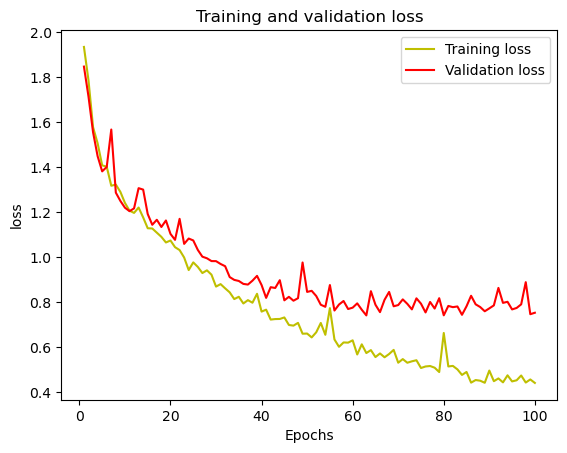

In [45]:
#Plot the training and validation accuracy and loss at each epoach
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

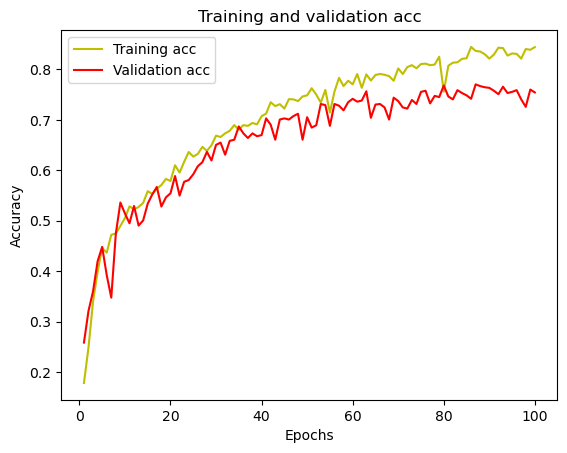

In [46]:
acc=history.history['acc']
val_acc=history.history['val_acc']
#epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'y',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
#Prediction on test data
y_pred=model.predict(x_test)
y_pred

28/28 [==============================] - 1s 34ms/step


array([[4.6474937e-02, 6.3933447e-02, 4.4815242e-03, ..., 9.1660989e-04,
        7.8661682e-04, 5.4884884e-05],
       [7.0610265e-03, 1.9768038e-01, 6.1140710e-01, ..., 1.5823942e-01,
        2.5212789e-02, 1.1509343e-04],
       [8.3862752e-01, 1.8145873e-04, 1.8377148e-03, ..., 1.5935320e-01,
        9.0155424e-08, 3.9252349e-08],
       ...,
       [3.7209599e-04, 1.0852720e-04, 1.2560122e-01, ..., 6.4643949e-01,
        2.2747760e-01, 6.2430338e-08],
       [4.4773960e-16, 3.9820061e-06, 5.3545377e-14, ..., 1.0459150e-13,
        1.4741654e-07, 9.9999583e-01],
       [1.5718531e-02, 5.2885348e-01, 2.9930624e-01, ..., 3.2948963e-02,
        1.1222089e-01, 2.7068981e-03]], dtype=float32)

In [48]:
#Convert predictions classes to one hot vectors
y_pred_classes=np.argmax(y_pred,axis=1) #argmax tells us that where the maximum probability or max value is
y_pred_classes

array([3, 2, 0, 3, 0, 4, 3, 3, 2, 0, 3, 2, 6, 0, 1, 1, 1, 3, 6, 5, 0, 3,
       4, 3, 0, 2, 1, 2, 3, 6, 6, 3, 5, 1, 6, 6, 0, 0, 1, 4, 3, 6, 1, 1,
       0, 0, 3, 3, 1, 0, 1, 2, 4, 6, 0, 0, 4, 0, 2, 3, 6, 0, 1, 0, 3, 6,
       0, 3, 3, 5, 5, 1, 0, 2, 3, 2, 6, 1, 6, 3, 6, 5, 6, 6, 5, 5, 2, 4,
       0, 1, 2, 6, 1, 5, 6, 4, 0, 2, 3, 1, 0, 4, 1, 0, 0, 0, 6, 6, 1, 0,
       0, 1, 0, 1, 0, 1, 6, 1, 5, 3, 1, 5, 6, 0, 1, 1, 4, 3, 1, 0, 3, 0,
       0, 6, 5, 4, 6, 6, 0, 1, 2, 6, 0, 3, 5, 0, 4, 0, 2, 0, 0, 4, 4, 1,
       5, 2, 1, 3, 0, 3, 0, 4, 2, 5, 5, 1, 4, 4, 4, 3, 3, 2, 0, 2, 3, 6,
       1, 5, 1, 6, 6, 2, 0, 0, 2, 2, 2, 3, 3, 5, 5, 5, 6, 3, 4, 6, 4, 3,
       2, 0, 0, 0, 3, 4, 0, 5, 5, 6, 6, 4, 2, 0, 6, 6, 6, 6, 2, 5, 5, 0,
       0, 1, 0, 1, 4, 3, 6, 2, 1, 3, 4, 3, 1, 6, 1, 3, 2, 3, 0, 1, 1, 0,
       1, 4, 3, 3, 1, 1, 6, 3, 4, 6, 3, 0, 1, 3, 5, 2, 1, 3, 2, 0, 4, 2,
       6, 4, 1, 2, 0, 0, 6, 0, 0, 1, 0, 0, 0, 6, 5, 3, 2, 3, 0, 6, 0, 1,
       0, 4, 1, 6, 1, 1, 3, 2, 4, 4, 4, 1, 0, 3, 0,

In [49]:
#Convert test data to one hot vectors
y_true=np.argmax(y_test,axis=1)
y_true

array([3, 4, 4, 3, 0, 4, 3, 3, 2, 0, 3, 5, 6, 1, 1, 1, 1, 2, 6, 5, 0, 3,
       0, 3, 2, 2, 1, 0, 3, 6, 6, 3, 4, 1, 6, 6, 0, 0, 1, 4, 3, 6, 1, 4,
       4, 0, 3, 3, 1, 0, 0, 0, 5, 6, 2, 0, 2, 0, 4, 3, 6, 2, 1, 0, 3, 6,
       0, 3, 1, 5, 5, 1, 0, 2, 1, 4, 6, 5, 6, 3, 6, 6, 6, 6, 5, 5, 2, 5,
       0, 0, 4, 6, 1, 5, 6, 5, 0, 2, 3, 1, 0, 4, 2, 2, 0, 0, 6, 6, 1, 0,
       0, 1, 2, 1, 4, 1, 6, 1, 5, 3, 1, 5, 6, 2, 1, 1, 4, 3, 1, 0, 3, 0,
       0, 6, 4, 4, 6, 6, 1, 0, 2, 6, 4, 3, 5, 5, 4, 1, 2, 0, 0, 4, 4, 1,
       5, 2, 0, 3, 0, 3, 5, 5, 0, 5, 2, 1, 2, 4, 4, 3, 3, 1, 0, 2, 3, 6,
       1, 5, 1, 6, 6, 2, 0, 0, 2, 1, 2, 3, 3, 5, 4, 5, 6, 2, 4, 6, 4, 3,
       2, 2, 2, 0, 3, 2, 0, 5, 5, 6, 6, 4, 4, 0, 6, 6, 6, 6, 2, 5, 5, 5,
       2, 1, 0, 1, 5, 3, 6, 2, 3, 3, 4, 3, 1, 6, 1, 3, 2, 3, 0, 1, 1, 0,
       1, 5, 3, 3, 4, 1, 6, 3, 2, 6, 3, 0, 1, 3, 5, 2, 1, 3, 2, 0, 0, 5,
       6, 4, 1, 4, 0, 0, 6, 1, 0, 1, 0, 0, 0, 6, 5, 3, 2, 3, 0, 6, 0, 1,
       0, 4, 1, 6, 5, 1, 0, 0, 4, 5, 5, 1, 0, 3, 0,

<AxesSubplot:>

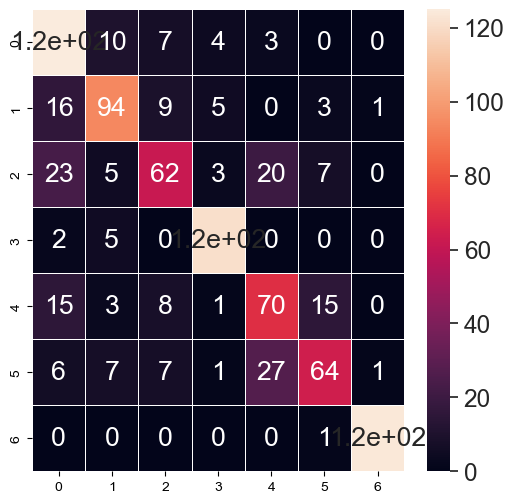

In [50]:
#Print confusion matrix

cm=confusion_matrix(y_true,y_pred_classes)

fig,ax=plt.subplots(figsize=(6,6))
sb.set(font_scale=1.6)
sb.heatmap(cm,annot=True,linewidths=.5,ax=ax)

In [51]:
np.sum(cm,axis=1)

array([149, 128, 120, 128, 112, 113, 125], dtype=int64)

In [52]:
np.diag(cm)

array([125,  94,  62, 121,  70,  64, 124], dtype=int64)

In [53]:
incorr_fraction=1-np.diag(cm)/np.sum(cm,axis=1)
incorr_fraction

array([0.16107383, 0.265625  , 0.48333333, 0.0546875 , 0.375     ,
       0.43362832, 0.008     ])

Text(0, 0.5, 'Fraction of incorrect predictions')

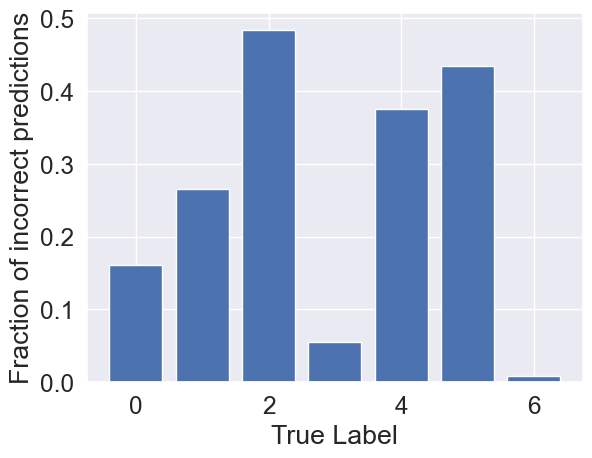

In [54]:
#Plot fractional incorrect misclassifications

incorr_fraction=1-np.diag(cm)/np.sum(cm,axis=1)
plt.bar(np.arange(7),incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')